In [1]:
# import dependencies
import pandas as pd
import json
import requests
from googleapiclient.discovery import build
from config import api_key
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import numpy as np

In [2]:
# Enter video id

video_id = "t6fIp7mMJ90"

In [3]:
def video_comments_to_df(video_id):
    # creating youtube resource object
    youtube = build('youtube', 'v3', developerKey=api_key)

    # get video title
    video_title = youtube.videos().list(part='snippet', id=video_id).execute()['items'][0]['snippet']['title']
    
    # retrieve youtube video results
    video_response = youtube.commentThreads().list(part='snippet,replies', videoId=video_id).execute()

    # create empty dataframe
    df = pd.DataFrame(columns=['id', 'author', 'thumbsup', 'text', '# of replies', 'replies'])

    # iterate video response
    while video_response:

    # export comments to a dataframe
        for i in range(len(video_response['items'])):
            replies = []
            id = video_response['items'][i]['snippet']['topLevelComment']['id']
            author = video_response['items'][i]['snippet']['topLevelComment']['snippet']['authorDisplayName']
            text = video_response['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal']
            replycount = video_response['items'][i]['snippet']['totalReplyCount']
            if replycount>0:
                try:
                    for reply in video_response['items'][i]['replies']['comments']:
                        reply = reply['snippet']['textOriginal']
                        replies.append(reply)
                except:
                    pass
            df = df.append({
                'id': id, 
                'author': author, 
                'thumbsup': int(video_response['items'][i]['snippet']['topLevelComment']['snippet']['likeCount']),
                'text': text, 
                '# of replies': replycount, 
                'replies': replies 
                }, 
                ignore_index=True)
        if 'nextPageToken' in video_response:
            video_response = youtube.commentThreads().list(
            part='snippet,replies',
            videoId=video_id,
            pageToken=video_response['nextPageToken']
            ).execute()
        else:
            break

    # change data types
    df['thumbsup'] = df['thumbsup'].astype(int)
    df['# of replies'] = df['# of replies'].astype(int)

    return df, video_title

In [4]:
df, video_title = video_comments_to_df(video_id)

In [5]:
# export to csv
df.to_csv(f'csv/{video_title} comments.csv', index=False)


In [6]:
# total reply checker

# for "Trinity", total replies should be >1868
total_replies = len(df) + sum(df['# of replies'])
print(f'Total replies: {total_replies}')

# SUCCESS


Total replies: 70205


In [7]:
print(len(df['author'].unique()))

46723


In [8]:
df['author'].value_counts()

useraccount                          82
Emily                                23
(Camille)_ vℓσg gσ тσ му ¢haηηєℓ!    22
J                                    20
50k challenge with 0 video           20
                                     ..
C'arrah Gabriel                       1
jasmine flower                        1
Mary B                                1
Elmerphant                            1
Boydism23                             1
Name: author, Length: 46723, dtype: int64

In [9]:
# get sentiment of comments
analyzer = SentimentIntensityAnalyzer()

comments = df['text'].to_list()

compound_values_list = []
positive_values_list = []
negative_values_list = []
neutral_values_list = []

for comment in comments:

    compound = analyzer.polarity_scores(comment)['compound']
    compound_values_list.append(compound)

    pos = analyzer.polarity_scores(comment)['pos']
    positive_values_list.append(pos)

    neg = analyzer.polarity_scores(comment)['neg']
    negative_values_list.append(neg)

    neu = analyzer.polarity_scores(comment)['neu']
    neutral_values_list.append(neu)

df['compound'] = compound_values_list
df['positive'] = positive_values_list
df['negative'] = negative_values_list
df['neutral'] = neutral_values_list

print(df['compound'].mean())
print(len(df['compound'] ))

0.2839269944630742
51292


In [10]:
# drop rows where compound and neutral are 0
df_dropped = df.drop(df[(df['compound'] == 0) & (df['neutral'] == 1)].index)

In [11]:
# plot the data
def plot(df, bin_count, title=''):
    plt.figure(figsize=(10, 6))
    plt.hist(df, bins=bin_count)
    plt.xlabel(f'{title} Sentiment')
    plt.ylabel('Number of Comments')
    plt.title(f'Sentiment Analysis of {video_title} Comments')

    # save the figure with white background
    plt.savefig(f'charts/{video_title} {title} Sentiment.png', transparent=True, facecolor='white')
    
    plt.show()

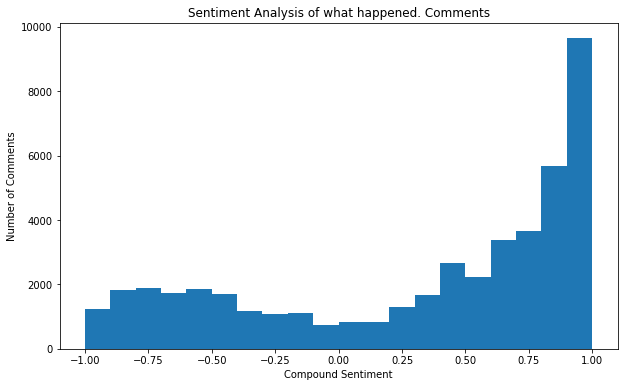

In [12]:
plot(df_dropped['compound'], 20, 'Compound')

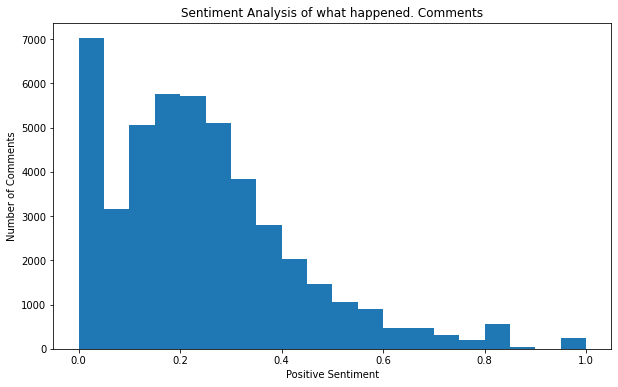

In [13]:
plot(df_dropped['positive'], 20, 'Positive')

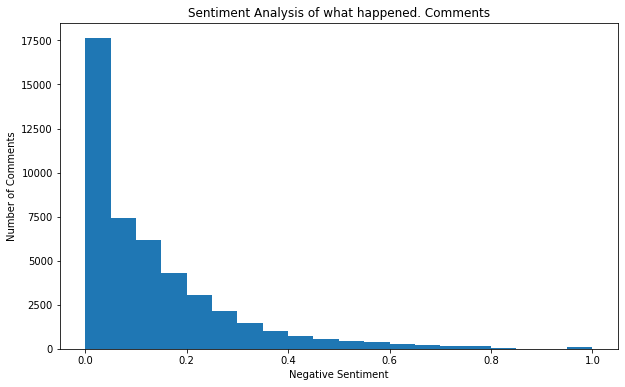

In [14]:
plot(df_dropped['negative'], 20, 'Negative')

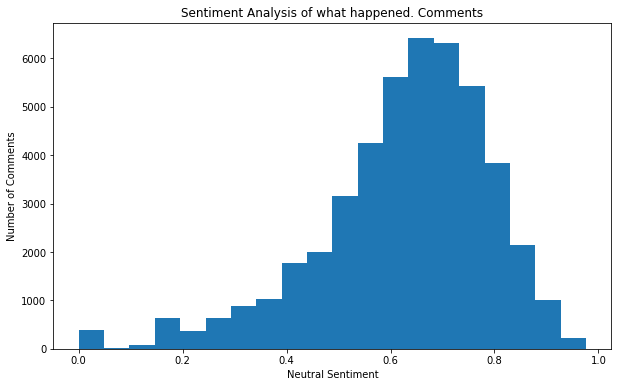

In [15]:
plot(df_dropped['neutral'], 20, 'Neutral')

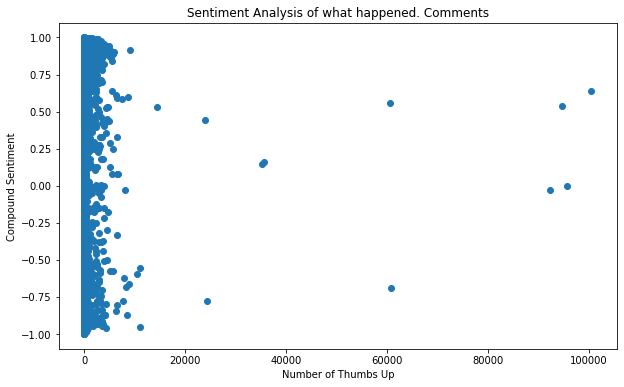

In [16]:
# create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['thumbsup'], df['compound'])
plt.xlabel('Number of Thumbs Up')
plt.ylabel('Compound Sentiment')
plt.title(f'Sentiment Analysis of {video_title} Comments')
plt.show()

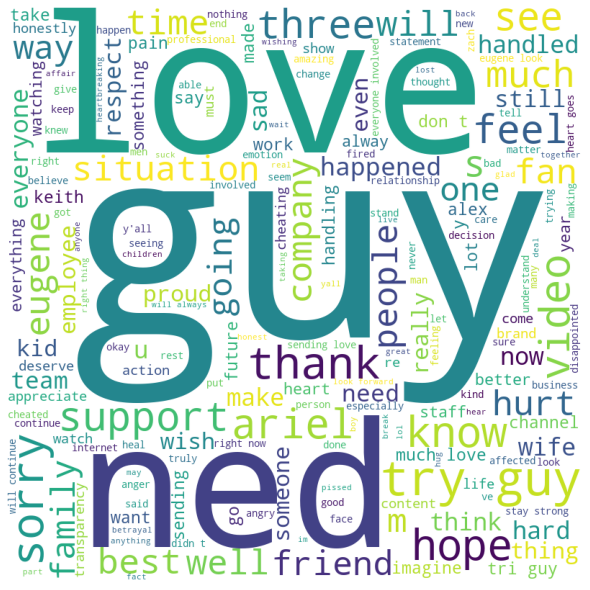

In [17]:
# wordcloud take 2
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.text:
    # typecaste each val to string
    val = str(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


In [18]:
# save the wordcloud
wordcloud.to_file(f'wordclouds/{video_title} wordcloud.png')